<a href="https://colab.research.google.com/github/shrey2144/supplier-reliability-predictor/blob/main/Predictive_Ananlysis_With_ML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix


In [ ]:
# Make sure 'Procurement KPI Analysis Dataset.csv' is uploaded to your Colab environment
# or adjust the path if it's stored elsewhere.
df = pd.read_csv('Procurement KPI Analysis Dataset.csv')
print("Initial DataFrame head after loading:")
print(df.head())
print("\nInitial DataFrame info:")
print(df.info())

Initial DataFrame head after loading:
      PO_ID         Supplier  Order_Date Delivery_Date    Item_Category  \
0  PO-00001        Alpha_Inc  2023-10-17    2023-10-25  Office Supplies   
1  PO-00002  Delta_Logistics  2022-04-25    2022-05-05  Office Supplies   
2  PO-00003         Gamma_Co  2022-01-26    2022-02-15              MRO   
3  PO-00004    Beta_Supplies  2022-10-09    2022-10-28        Packaging   
4  PO-00005  Delta_Logistics  2022-09-08    2022-09-20    Raw Materials   

  Order_Status  Quantity  Unit_Price  Negotiated_Price  Defective_Units  \
0    Cancelled      1176       20.13             17.81              NaN   
1    Delivered      1509       39.32             37.34            235.0   
2    Delivered       910       95.51             92.26             41.0   
3    Delivered      1344       99.85             95.52            112.0   
4    Delivered      1180       64.07             60.53            171.0   

  Compliance  
0        Yes  
1        Yes  
2        Yes  


EDA Visualizations:

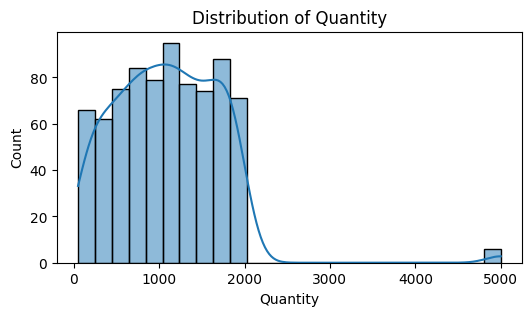

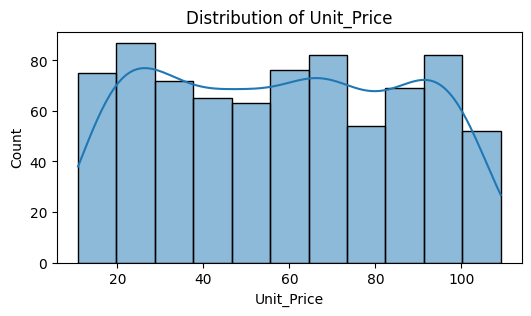

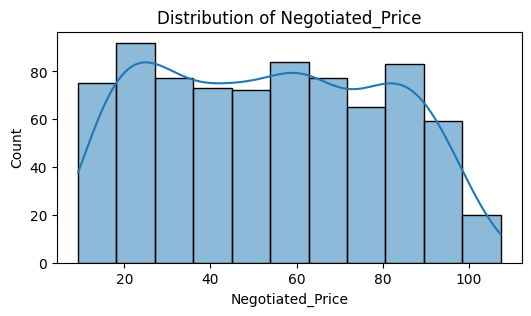

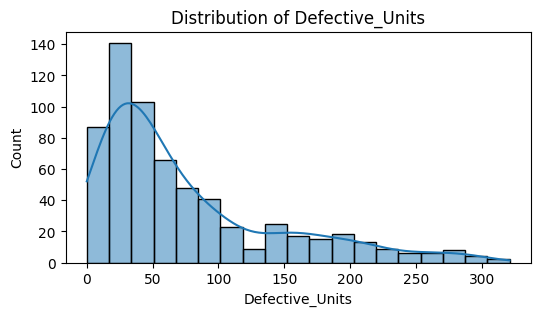

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

for col in df.select_dtypes(include='number').columns:
    plt.figure(figsize=(6, 3))
    sns.histplot(df[col], kde=True)
    plt.title(f'Distribution of {col}')
    plt.show()

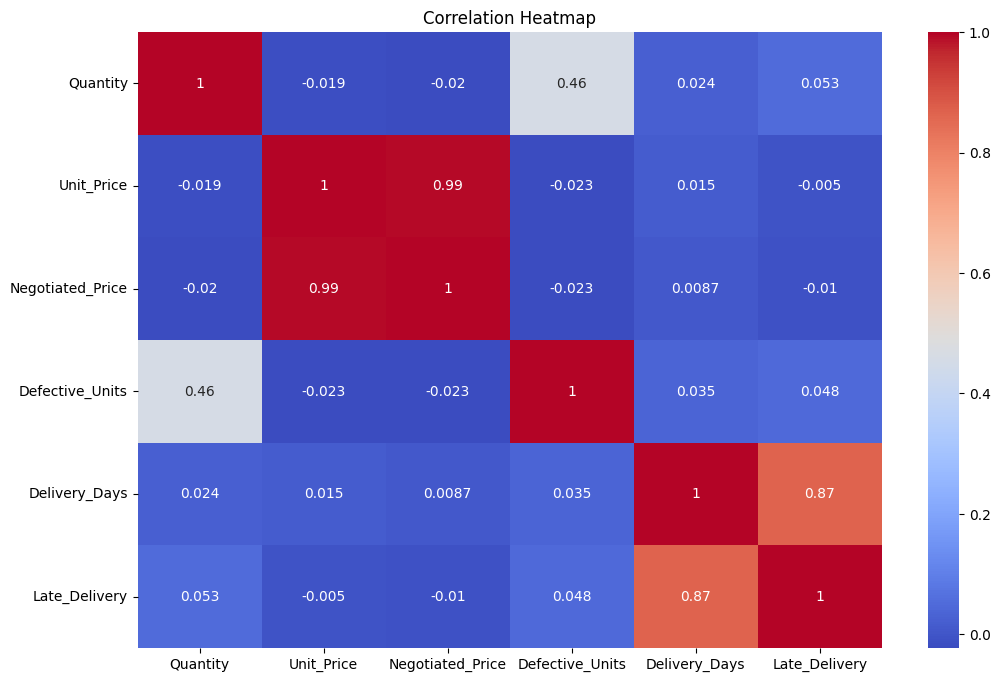

In [ ]:
plt.figure(figsize=(12, 8))
# Select only numerical columns for correlation calculation
numerical_df = df.select_dtypes(include=['number'])
sns.heatmap(numerical_df.corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

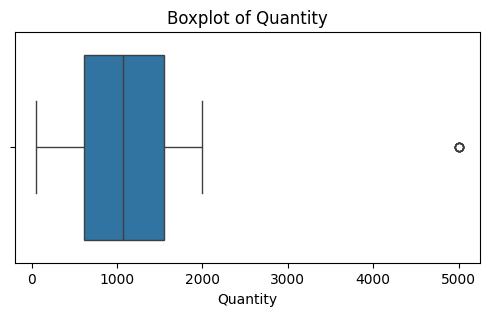

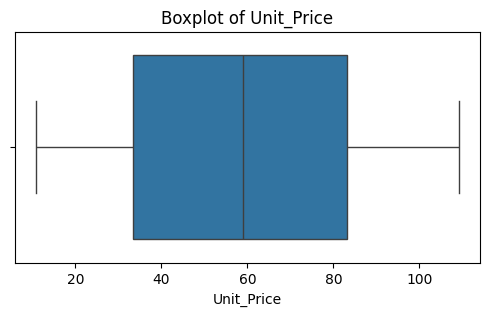

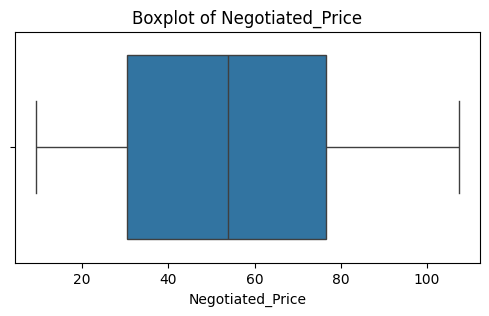

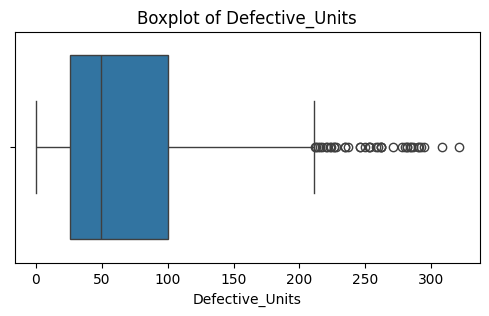

In [ ]:
for col in df.select_dtypes(include='number').columns:
    plt.figure(figsize=(6, 3))
    sns.boxplot(x=df[col])
    plt.title(f'Boxplot of {col}')
    plt.show()


In [ ]:
# --- 2. Initial Date Conversions and Feature Creation ---
df['Order_Date'] = pd.to_datetime(df['Order_Date'])
df['Delivery_Date'] = pd.to_datetime(df['Delivery_Date'])
df['Delivery_Days'] = (df['Delivery_Date'] - df['Order_Date']).dt.days
df['Late_Delivery'] = (df['Delivery_Days'] > 10).astype(int)
print("\nDataFrame head after date conversions and new feature creation:")
print(df.head())


DataFrame head after date conversions and new feature creation:
      PO_ID         Supplier Order_Date Delivery_Date    Item_Category  \
0  PO-00001        Alpha_Inc 2023-10-17    2023-10-25  Office Supplies   
1  PO-00002  Delta_Logistics 2022-04-25    2022-05-05  Office Supplies   
2  PO-00003         Gamma_Co 2022-01-26    2022-02-15              MRO   
3  PO-00004    Beta_Supplies 2022-10-09    2022-10-28        Packaging   
4  PO-00005  Delta_Logistics 2022-09-08    2022-09-20    Raw Materials   

  Order_Status  Quantity  Unit_Price  Negotiated_Price  Defective_Units  \
0    Cancelled      1176       20.13             17.81              NaN   
1    Delivered      1509       39.32             37.34            235.0   
2    Delivered       910       95.51             92.26             41.0   
3    Delivered      1344       99.85             95.52            112.0   
4    Delivered      1180       64.07             60.53            171.0   

  Compliance  Delivery_Days  Late_Deliv

In [ ]:
# --- 3. Handle Missing values: Fill NaN in 'Defective_Units' with 0 ---
df['Defective_Units'] = df['Defective_Units'].fillna(0)
print(f"\nMissing values in 'Defective_Units' after filling: {df['Defective_Units'].isnull().sum()}")



Missing values in 'Defective_Units' after filling: 0


In [ ]:
# --- NEW STEP: Handle Missing values in 'Delivery_Days' (fill with median) ---
# Calculate the median of Delivery_Days BEFORE dropping columns for X and y
median_delivery_days = df['Delivery_Days'].median()
df['Delivery_Days'] = df['Delivery_Days'].fillna(median_delivery_days)
print(f"\nMissing values in 'Delivery_Days' after filling: {df['Delivery_Days'].isnull().sum()}")
print(f"Filled 'Delivery_Days' NaNs with median: {median_delivery_days}")



Missing values in 'Delivery_Days' after filling: 0
Filled 'Delivery_Days' NaNs with median: 11.0


In [ ]:
# --- 4. One-Hot Encode categorical columns ---
categorical_cols = ['Supplier', 'Item_Category', 'Order_Status', 'Compliance']
df = pd.get_dummies(df, columns=categorical_cols, drop_first=True)
print("\nDataFrame columns after One-Hot Encoding:")
print(df.columns.tolist())


DataFrame columns after One-Hot Encoding:
['PO_ID', 'Order_Date', 'Delivery_Date', 'Quantity', 'Unit_Price', 'Negotiated_Price', 'Defective_Units', 'Delivery_Days', 'Late_Delivery', 'Supplier_Beta_Supplies', 'Supplier_Delta_Logistics', 'Supplier_Epsilon_Group', 'Supplier_Gamma_Co', 'Item_Category_MRO', 'Item_Category_Office Supplies', 'Item_Category_Packaging', 'Item_Category_Raw Materials', 'Order_Status_Delivered', 'Order_Status_Partially Delivered', 'Order_Status_Pending', 'Compliance_Yes']


In [ ]:
# --- 5. Drop irrelevant columns after encoding ---
columns_to_drop = ['PO_ID', 'Order_Date', 'Delivery_Date']
df = df.drop(columns=columns_to_drop)
print("\nDataFrame columns after dropping irrelevant columns:")
print(df.columns.tolist())


DataFrame columns after dropping irrelevant columns:
['Quantity', 'Unit_Price', 'Negotiated_Price', 'Defective_Units', 'Delivery_Days', 'Late_Delivery', 'Supplier_Beta_Supplies', 'Supplier_Delta_Logistics', 'Supplier_Epsilon_Group', 'Supplier_Gamma_Co', 'Item_Category_MRO', 'Item_Category_Office Supplies', 'Item_Category_Packaging', 'Item_Category_Raw Materials', 'Order_Status_Delivered', 'Order_Status_Partially Delivered', 'Order_Status_Pending', 'Compliance_Yes']


In [ ]:
# --- 6. Define features (X) and target (y) ---
X = df.drop(columns=['Late_Delivery']) # Features are all columns except 'Late_Delivery'
y = df['Late_Delivery'] # Target variable

In [ ]:
print(f"\nShape of X: {X.shape}")
print(f"Shape of y: {y.shape}")


Shape of X: (777, 17)
Shape of y: (777,)


In [ ]:
# --- 7. Feature Scaling for numerical features ---
# Identify numerical columns (exclude the newly created binary columns from get_dummies)
numerical_cols = ['Quantity', 'Unit_Price', 'Negotiated_Price', 'Defective_Units', 'Delivery_Days']
scaler = StandardScaler()
X[numerical_cols] = scaler.fit_transform(X[numerical_cols])
print("\nFirst 5 rows of X after Feature Scaling:")
print(X.head())

import joblib

# Save the fitted scaler and the numeric column names
joblib.dump(scaler, 'scaler.pkl')
joblib.dump(numerical_cols, 'numeric_cols.pkl')


First 5 rows of X after Feature Scaling:
   Quantity  Unit_Price  Negotiated_Price  Defective_Units  Delivery_Days  \
0  0.125635   -1.358598         -1.374743        -0.895304      -0.519286   
1  0.639979   -0.675272         -0.625839         2.514110      -0.148606   
2 -0.285221    1.325566          1.480140        -0.300470       1.704794   
3  0.385124    1.480107          1.605149         0.729608       1.519454   
4  0.131814    0.206037          0.263411         1.585589       0.222074   

   Supplier_Beta_Supplies  Supplier_Delta_Logistics  Supplier_Epsilon_Group  \
0                   False                     False                   False   
1                   False                      True                   False   
2                   False                     False                   False   
3                    True                     False                   False   
4                   False                      True                   False   

   Supplier_Gamma_Co

['numeric_cols.pkl']

In [ ]:
# --- 8. Split the data into training and testing sets ---
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"\nTraining and Testing Split Shapes:")
print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")




Training and Testing Split Shapes:
X_train shape: (621, 17)
X_test shape: (156, 17)
y_train shape: (621,)
y_test shape: (156,)


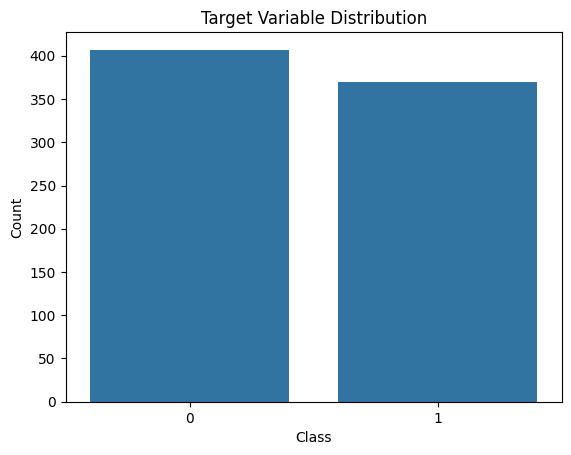

In [ ]:
# Visualizing class distribution in the target variable
sns.countplot(x=y)
plt.title('Target Variable Distribution')
plt.xlabel('Class')
plt.ylabel('Count')
plt.show()


In [ ]:
# --- Now you can proceed with Model Training and Evaluation ---
print("\n--- Proceeding to Model Training and Evaluation ---")
model = LogisticRegression(random_state=42, solver='liblinear')
print("Training the Logistic Regression model...")
model.fit(X_train, y_train)
print("Model training complete.")


--- Proceeding to Model Training and Evaluation ---
Training the Logistic Regression model...
Model training complete.


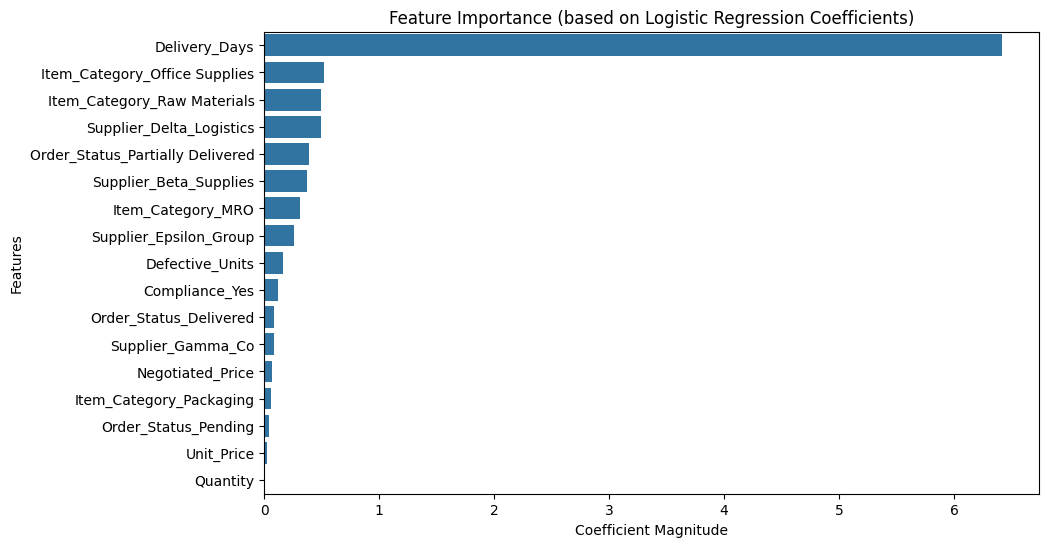

In [ ]:
# --- Feature Importance using Logistic Regression Coefficients ---
import numpy as np
import pandas as pd

coefficients = model.coef_[0]
features = X.columns
importance_df = pd.DataFrame({
    'Feature': features,
    'Importance': np.abs(coefficients)
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df)
plt.title('Feature Importance (based on Logistic Regression Coefficients)')
plt.xlabel('Coefficient Magnitude')
plt.ylabel('Features')
plt.show()

In [ ]:
y_pred = model.predict(X_test)

print("\n--- Model Evaluation ---")
print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print(f"Precision: {precision_score(y_test, y_pred):.4f}")
print(f"Recall: {recall_score(y_test, y_pred):.4f}")
print(f"F1-Score: {f1_score(y_test, y_pred):.4f}")
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))


--- Model Evaluation ---
Accuracy: 0.9359
Precision: 0.9324
Recall: 0.9324
F1-Score: 0.9324

Confusion Matrix:
[[77  5]
 [ 5 69]]


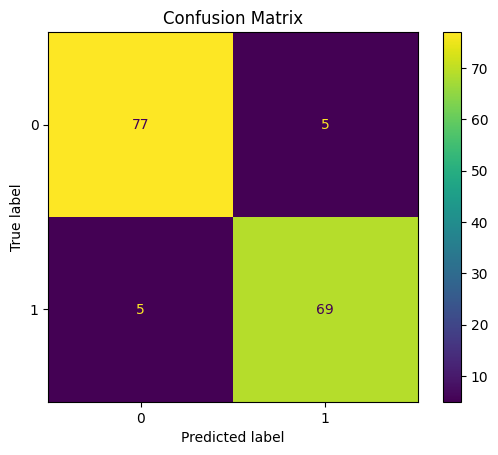

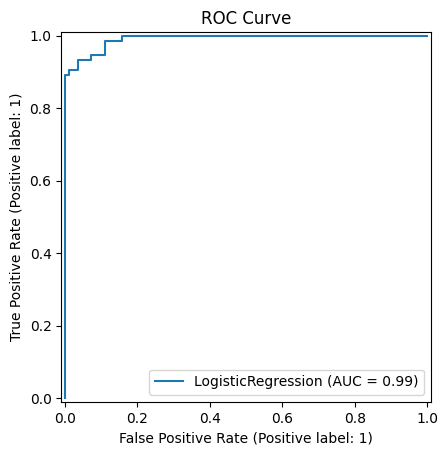

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay, RocCurveDisplay

ConfusionMatrixDisplay.from_estimator(model, X_test, y_test)
plt.title('Confusion Matrix')
plt.show()

RocCurveDisplay.from_estimator(model, X_test, y_test)
plt.title('ROC Curve')
plt.show()


Train Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier

# Train Random Forest
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, y_train)
y_rf_pred = rf_model.predict(X_test)


# Evaluation
print("\n--- Random Forest Evaluation ---")
print(f"Accuracy: {accuracy_score(y_test, y_rf_pred):.4f}")
print(f"Precision: {precision_score(y_test, y_rf_pred):.4f}")
print(f"Recall: {recall_score(y_test, y_rf_pred):.4f}")
print(f"F1-Score: {f1_score(y_test, y_rf_pred):.4f}")
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_rf_pred))



--- Random Forest Evaluation ---
Accuracy: 0.9487
Precision: 0.9583
Recall: 0.9324
F1-Score: 0.9452
Confusion Matrix:
[[79  3]
 [ 5 69]]


Train XGBoost

In [ ]:
import xgboost as xgb

# Train XGBoost
xgb_model = xgb.XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')
xgb_model.fit(X_train, y_train)
y_xgb_pred = xgb_model.predict(X_test)

# Evaluation
print("\n--- XGBoost Evaluation ---")
print(f"Accuracy: {accuracy_score(y_test, y_xgb_pred):.4f}")
print(f"Precision: {precision_score(y_test, y_xgb_pred):.4f}")
print(f"Recall: {recall_score(y_test, y_xgb_pred):.4f}")
print(f"F1-Score: {f1_score(y_test, y_xgb_pred):.4f}")
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_xgb_pred))



--- XGBoost Evaluation ---
Accuracy: 0.9359
Precision: 0.9324
Recall: 0.9324
F1-Score: 0.9324
Confusion Matrix:
[[77  5]
 [ 5 69]]


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [07:45:24] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Compare All Models in a Table

In [ ]:
results = pd.DataFrame({
    "Model": ["Logistic Regression", "Random Forest", "XGBoost"],
    "Accuracy": [
        accuracy_score(y_test, y_pred),
        accuracy_score(y_test, y_rf_pred),
        accuracy_score(y_test, y_xgb_pred)
    ],
    "Precision": [
        precision_score(y_test, y_pred),
        precision_score(y_test, y_rf_pred),
        precision_score(y_test, y_xgb_pred)
    ],
    "Recall": [
        recall_score(y_test, y_pred),
        recall_score(y_test, y_rf_pred),
        recall_score(y_test, y_xgb_pred)
    ],
    "F1 Score": [
        f1_score(y_test, y_pred),
        f1_score(y_test, y_rf_pred),
        f1_score(y_test, y_xgb_pred)
    ]
})

print("\n--- Model Comparison Table ---")
print(results)



--- Model Comparison Table ---
                 Model  Accuracy  Precision    Recall  F1 Score
0  Logistic Regression  0.935897   0.932432  0.932432  0.932432
1        Random Forest  0.948718   0.958333  0.932432  0.945205
2              XGBoost  0.935897   0.932432  0.932432  0.932432


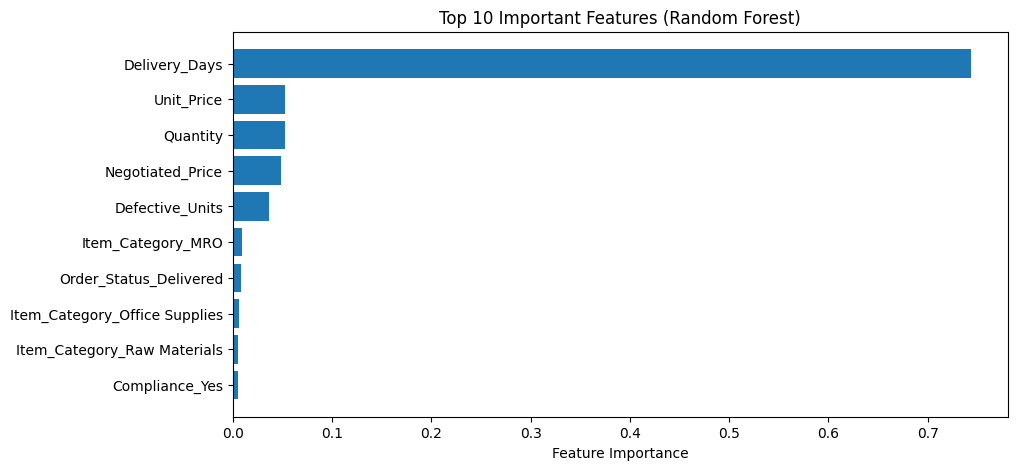

In [ ]:
import matplotlib.pyplot as plt

importances = rf_model.feature_importances_
features = X.columns
sorted_idx = importances.argsort()[-10:]

plt.figure(figsize=(10, 5))
plt.barh(range(len(sorted_idx)), importances[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), [features[i] for i in sorted_idx])
plt.xlabel("Feature Importance")
plt.title("Top 10 Important Features (Random Forest)")
plt.show()


In [ ]:
# Drop 'Delivery_Days' for real-world prediction
X_real = X.drop(columns=['Delivery_Days'])

# Re-split
X_train_real, X_test_real, y_train_real, y_test_real = train_test_split(X_real, y, test_size=0.2, random_state=42)

# Retrain Random Forest
rf_real = RandomForestClassifier(random_state=42)
rf_real.fit(X_train_real, y_train_real)
y_real_pred = rf_real.predict(X_test_real)

# Evaluate
print("\n--- Real-World Model Evaluation (No Delivery_Days) ---")
print(f"Accuracy: {accuracy_score(y_test_real, y_real_pred):.4f}")
print(f"Precision: {precision_score(y_test_real, y_real_pred):.4f}")
print(f"Recall: {recall_score(y_test_real, y_real_pred):.4f}")
print(f"F1-Score: {f1_score(y_test_real, y_real_pred):.4f}")



--- Real-World Model Evaluation (No Delivery_Days) ---
Accuracy: 0.5064
Precision: 0.4769
Recall: 0.4189
F1-Score: 0.4460
